In [239]:
import requests
import os
import pandas as pd
import re
from lxml import html
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import json
import itertools
import numpy as np
import networkx as nx
from scipy import stats

### Scraping the data

For collecting data I used API Vkontakte. At first I downloaded a list of ids of my friends.

In [555]:
url = 'https://api.vk.com/method/friends.get?v=5.131&access_token=###'
page = requests.get(url)
html = page.text
my_dict = json.loads(html)
list_of_nodes = my_dict['response']['items']

After that I collected the dictionary, where the keys are my friends, and values are their friends.

In [556]:
dict_of_friends = {}
i = 0
nodes_to_delete = []
for node in list_of_nodes:
    print(node)
    url = 'https://api.vk.com/method/friends.get?user_id={}&v=5.131&access_token=###'.format(node)
    page = requests.get(url)
    html = page.text
    if 'error' in html:
        nodes_to_delete.append(node)
        continue
    my_dict = json.loads(html)
    list_of_his_frieds = my_dict['response']['items']
    dict_of_friends[node] = list_of_his_frieds
    i+=1
    if i==2:
        time.sleep(1)
        i = 0

After that out of their friends I chose only mutual friends with me and created set of pairs, which will be the edges of the graph.

In [557]:
list_of_edges = []
for my_friend in dict_of_friends:
    for his_friend in dict_of_friends[my_friend]:
        if his_friend in dict_of_friends:
            list_of_edges.append([my_friend,his_friend])
    for each_friend in dict_of_friends:
        if my_friend in dict_of_friends[each_friend]:
            dict_of_friends[each_friend].pop(dict_of_friends[each_friend].index(my_friend))

Let's see what we are dealing with:

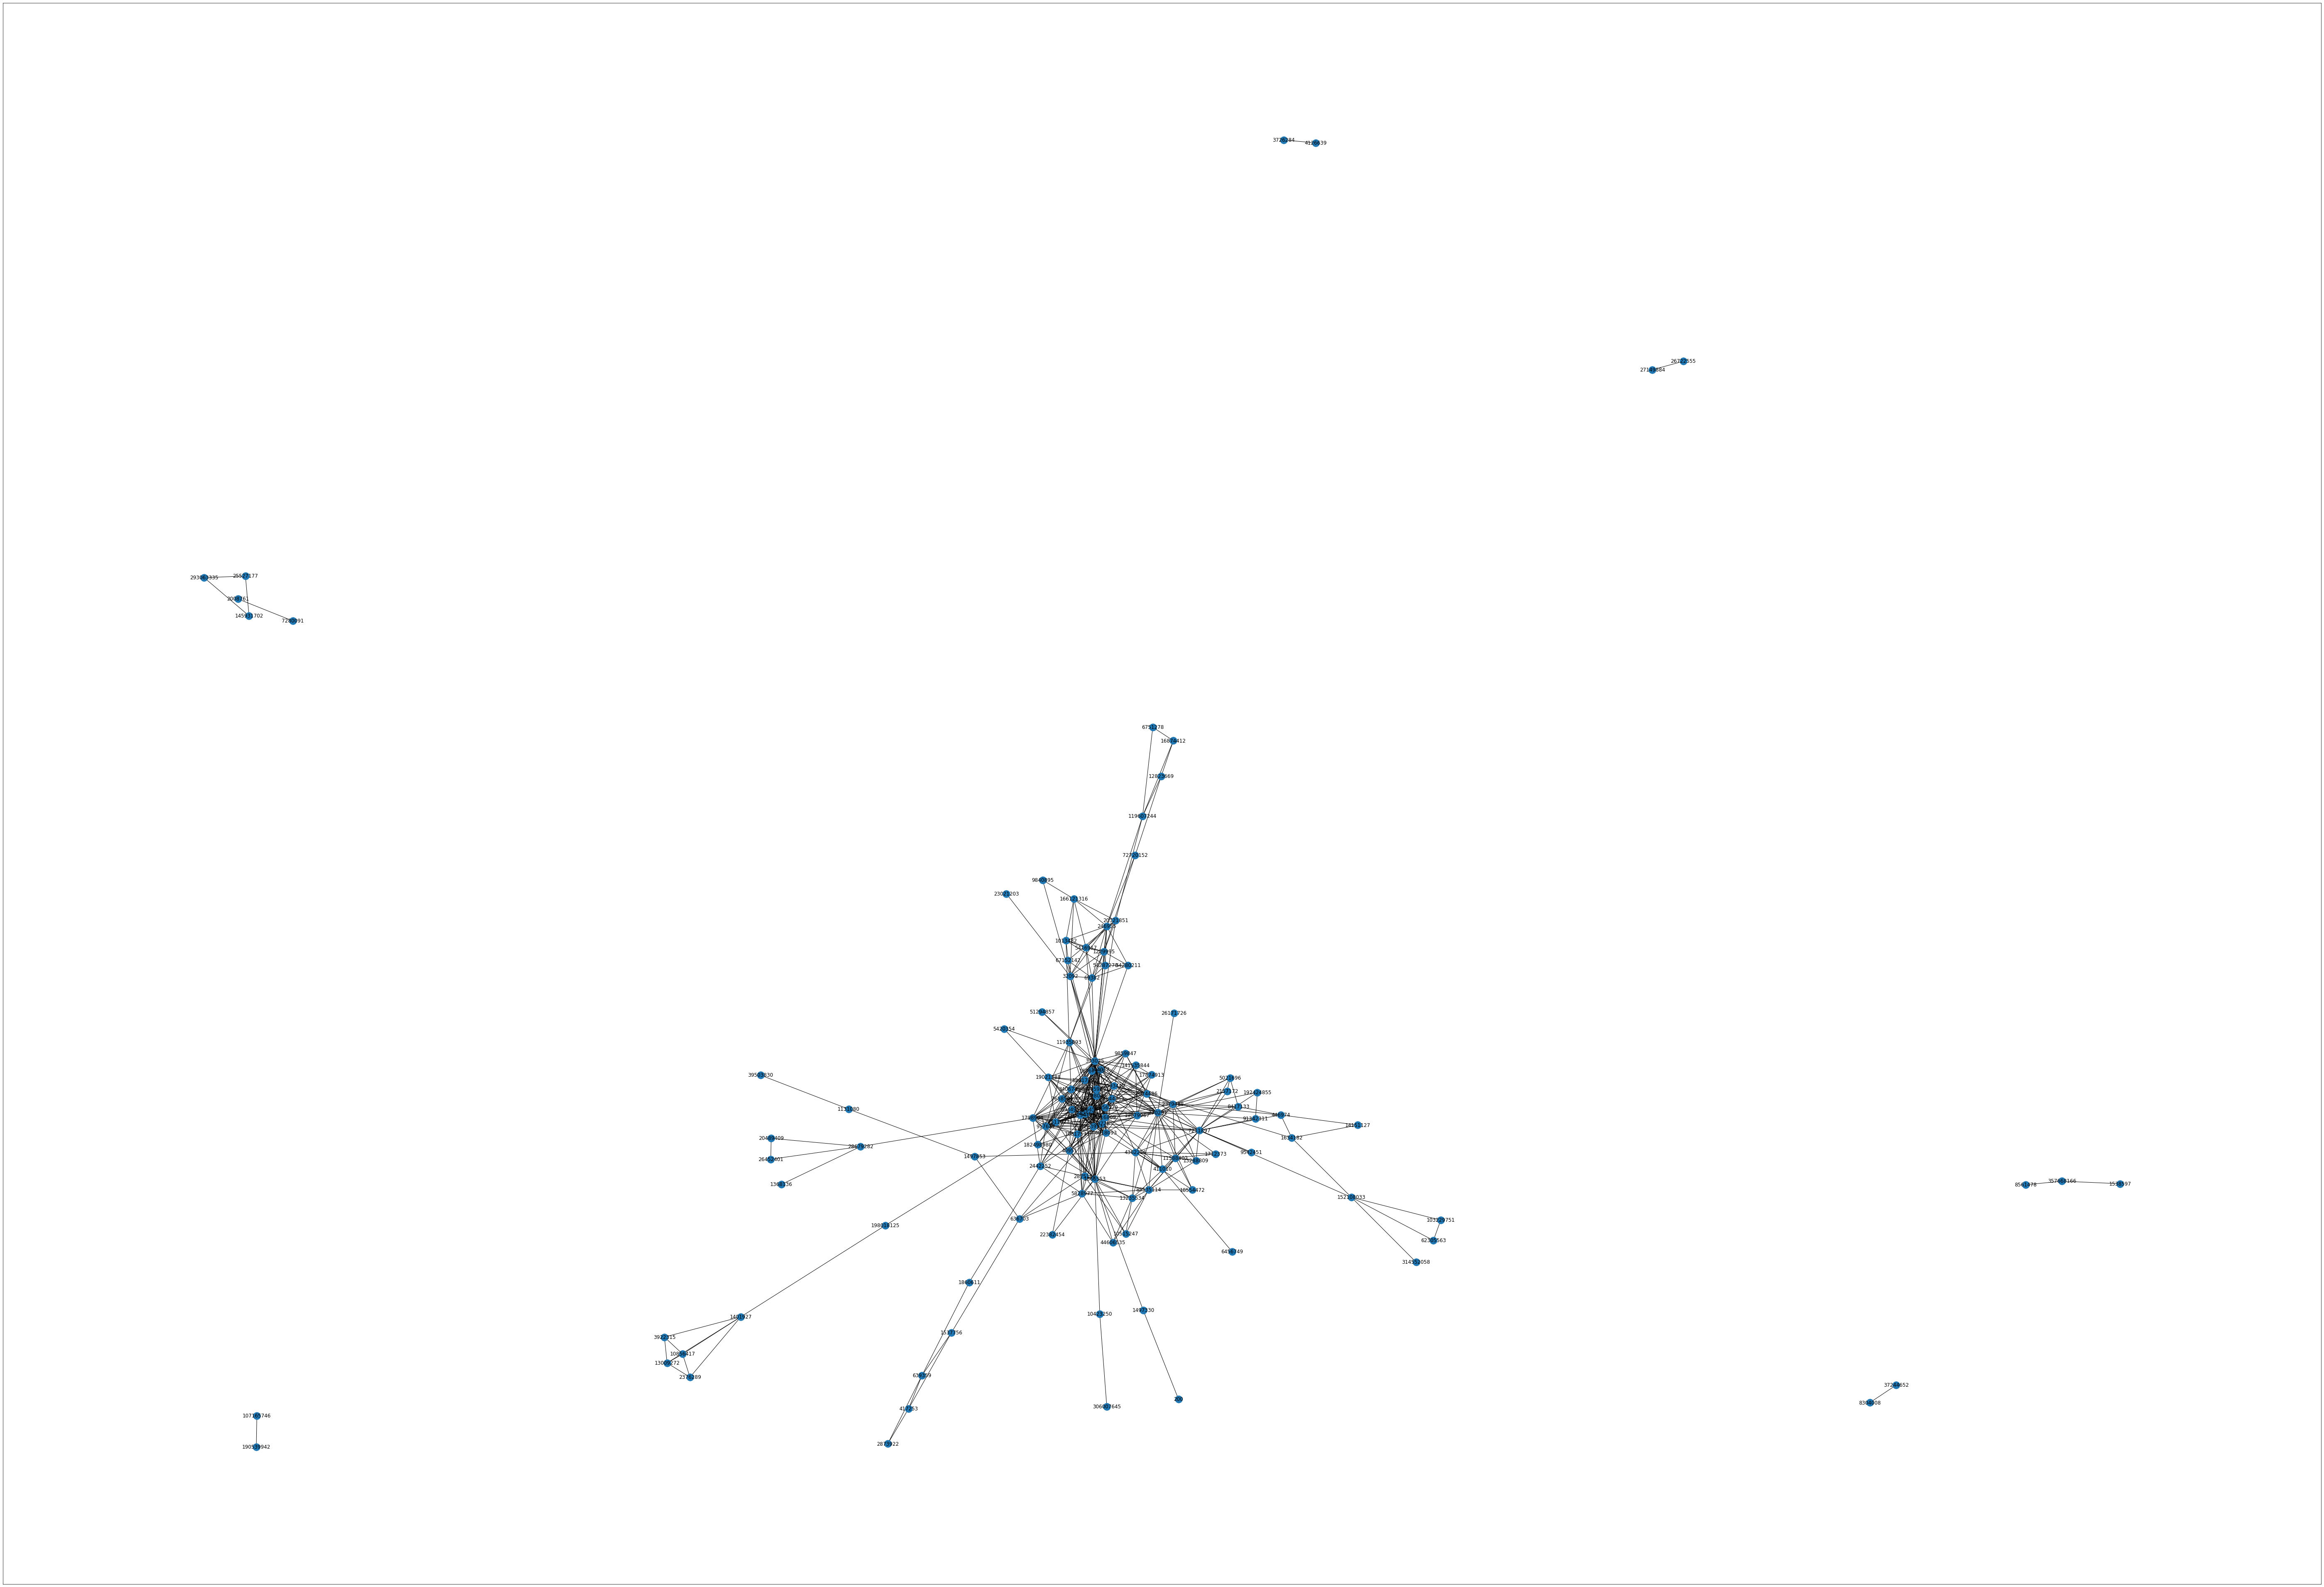

In [70]:
plt.figure(figsize=(100, 70))
G = nx.Graph(list_of_edges)
nx.draw_networkx(G)

I decided to analyse the biggest connected component, since it still has > 100 nodes, and ignore the marginal elements of the graph.

In [72]:
def select_gygantic_component(g: nx.Graph) -> nx.Graph:
    i = {}
    for cc in nx.connected_components(g):
        if len(cc) > len(i):
            i = cc
    nodes_to_remove = []
    for node in g.nodes:
        if node not in i:
            nodes_to_remove.append(node)
    g.remove_nodes_from(nodes_to_remove)
    return g

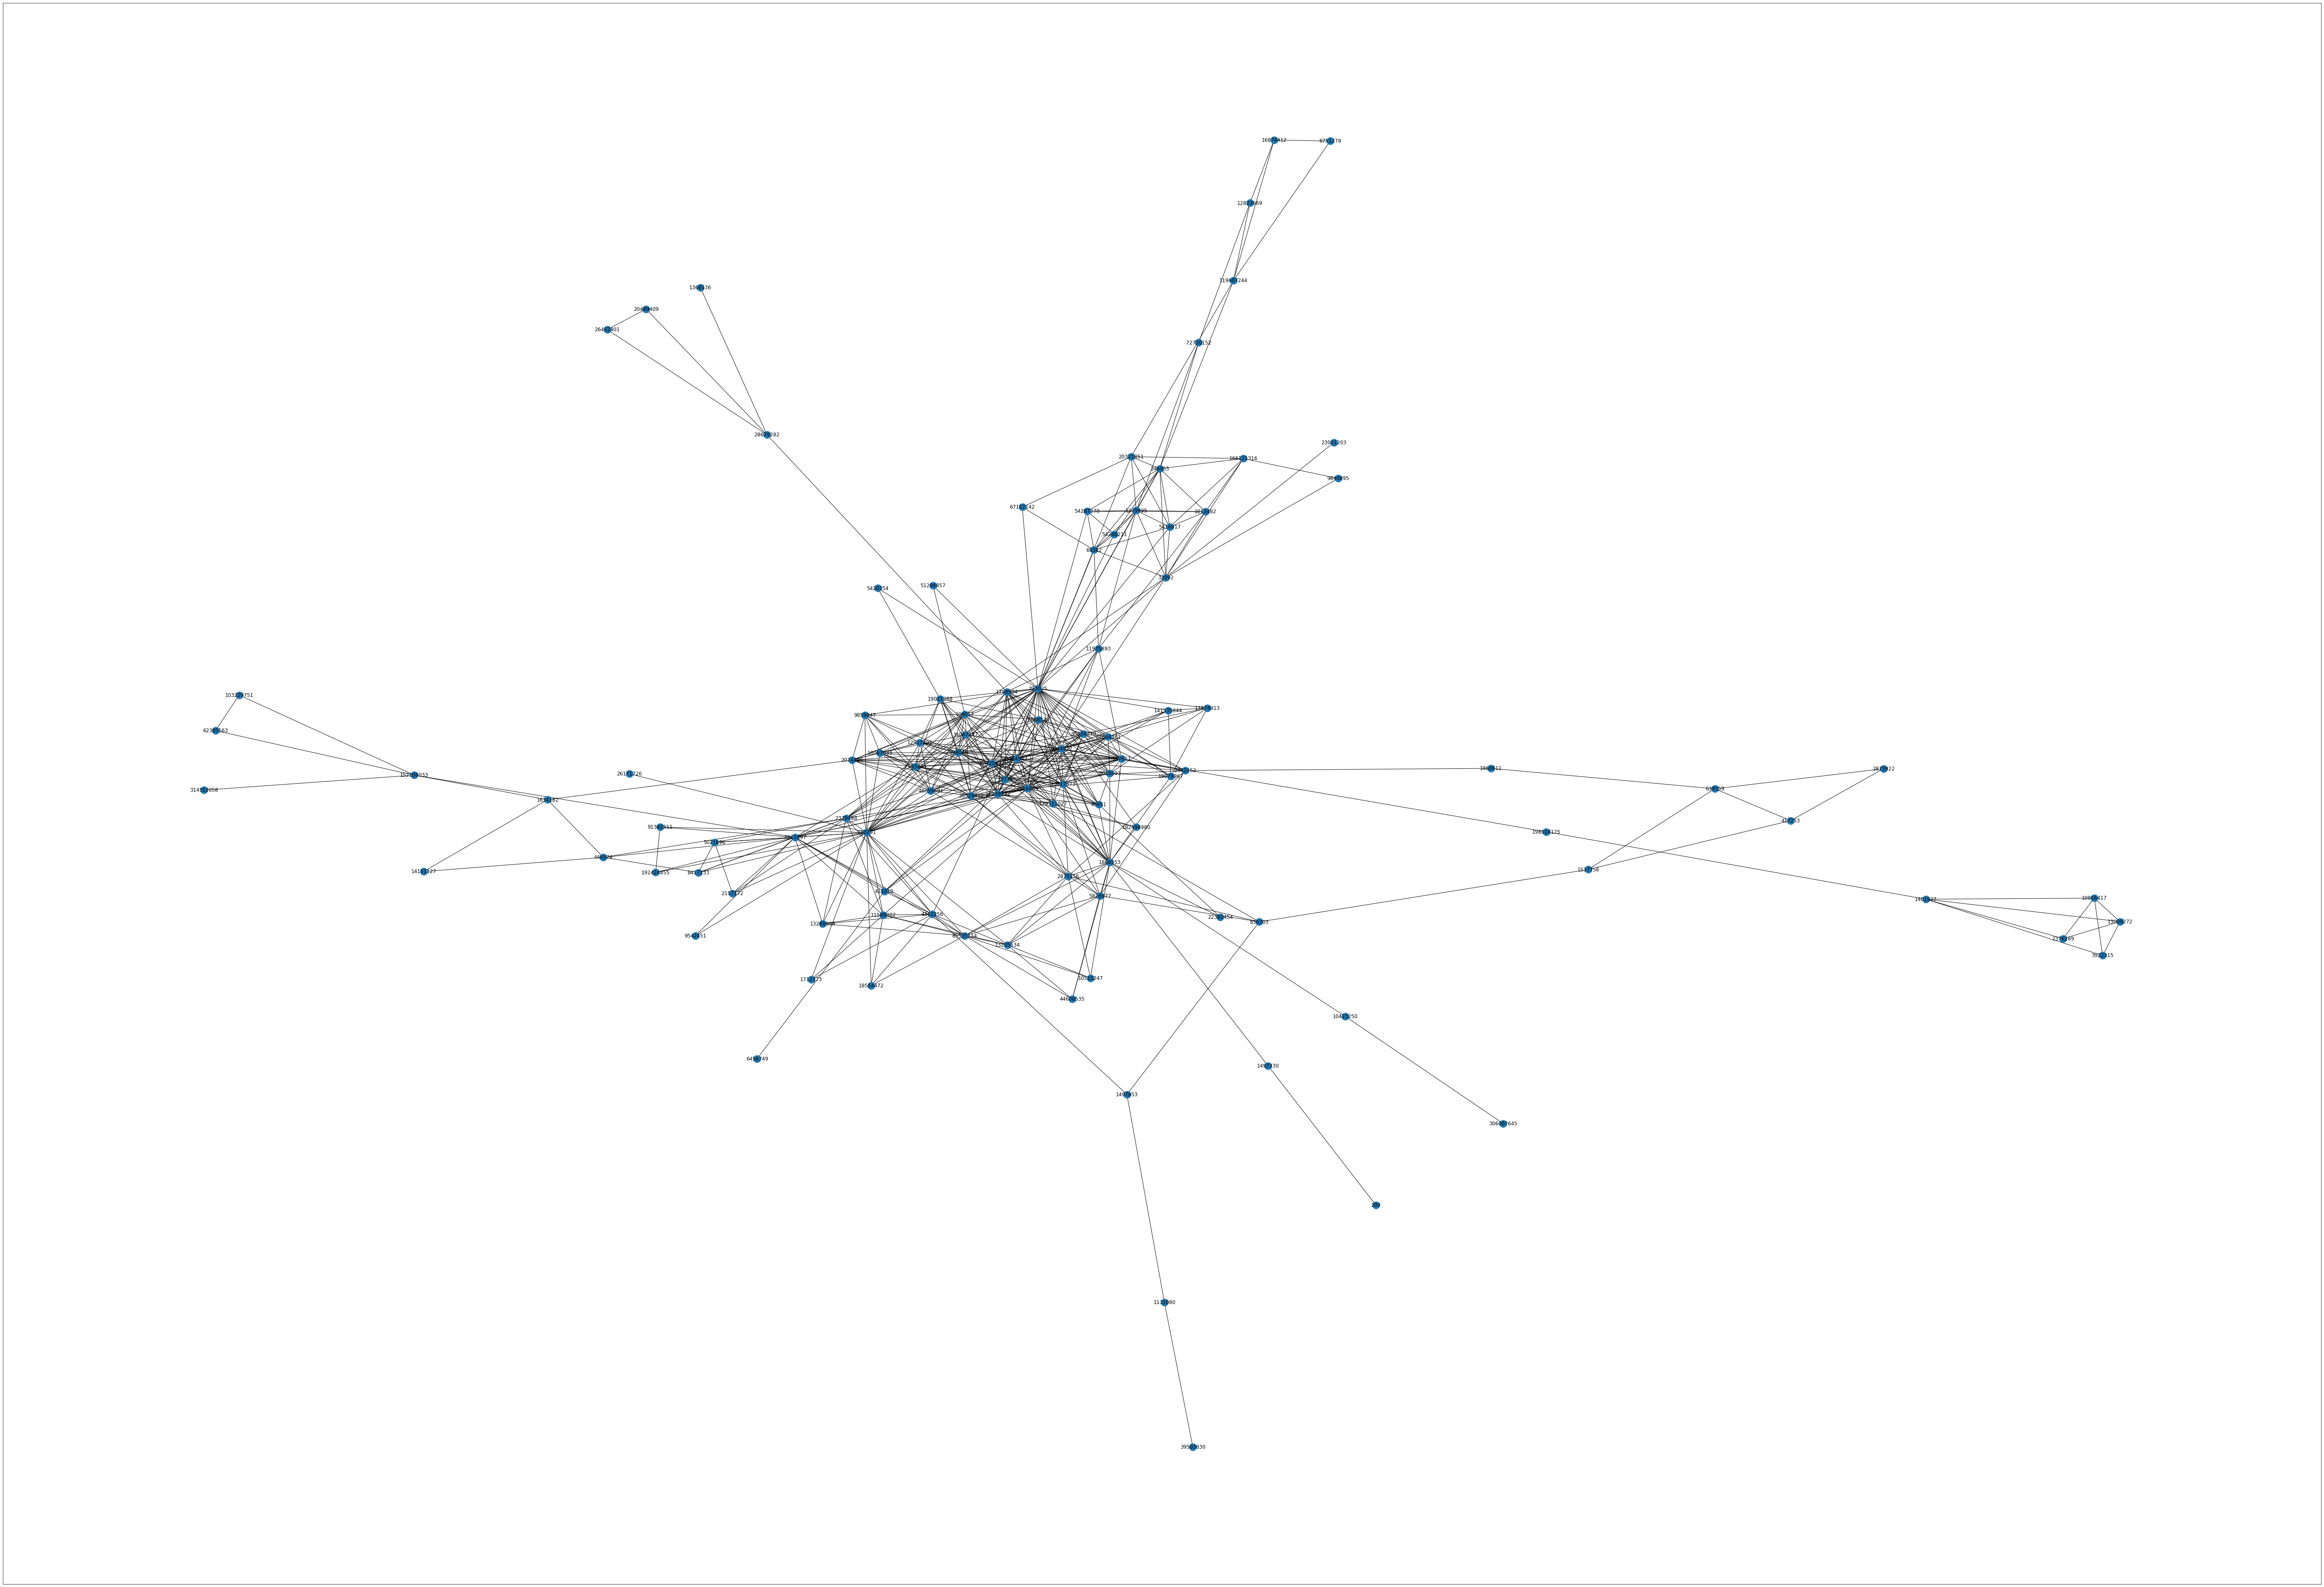

In [75]:
plt.figure(figsize=(100, 70))
gg = select_gygantic_component(G)
nx.draw_networkx(gg)

In [77]:
len(gg.nodes)

108

After that I extract additional information from the API, which will make the attributes for my graph. I decided to collect names and also information about the university a person was going to.

In [558]:
url = 'https://api.vk.com/method/friends.get?v=5.131&fields=universities&access_token=###'
page = requests.get(url)
html = page.text
my_dict = json.loads(html)

In [559]:
dict_of_names = {}
dict_of_unis = {}
for item in my_dict['response']['items']:
    dict_of_names[item['id']] = item['first_name']+' '+item['last_name']
    if 'universities' in item:
        if len(item['universities'])>0:
            dict_of_unis[item['id']] = item['universities'][0]['name']
        else:
            dict_of_unis[item['id']] = 'no info'
    else:
        dict_of_unis[item['id']] = 'no info'

I would like to color my nodes depending on the Uni the person attended. But the list of universities is very big. I perform some operations which include finding most common Unis, and putting the rest of them in "other" category.

In [129]:
set_of_unis = []
for key, value in dict_of_unis.items():
    set_of_unis.append(value)
Counter(set_of_unis).most_common()

[('no info', 52),
 ('ФИНЭК', 42),
 ('other', 24),
 ('СПбГУ', 11),
 ('НГУ им. Лесгафта (бывш. СПбГУФК)', 4),
 ('КФУ (бывш. КГУ им. Ульянова-Ленина)', 3),
 ('СПбГУТД', 2),
 ('ЕУ СПб', 2),
 ('ПГТУ', 2),
 ('СПбГК им. Римского-Корсакова', 2),
 ('СПбПУ Петра Великого (Политех)', 2),
 ('СПХФА', 2),
 ('Университет ИТМО', 2)]

In [130]:
for item in dict_of_unis:
    if dict_of_unis[item] in ['СПбГЭУ (ранее ФИНЭК, ИНЖЭКОН, СПбГУСЭ)','СПбГЭУ (ФИНЭК)','СПбГЭУ']:
        dict_of_unis.update({item:'ФИНЭК'})
    if dict_of_unis[item] == 'ПГТУ (бывш. МарГТУ)':
        dict_of_unis.update({item:'ПГТУ'})
    if dict_of_unis[item] == 'СПбГУФК им. Лесгафта':
        dict_of_unis.update({item:'НГУ им. Лесгафта (бывш. СПбГУФК)'})
    if dict_of_unis[item] in ['Tampereen ammattikorkeakoulu (TAMK)',
                              'ТГУ (бывш. ТолПИ, филиал СГПУ)',
                              'ПетрГУ',
                              'СПбГУГА',
                              'СПГГУ (бывш. СПГГИ (ТУ) им. Плеханова)',
                              'РУДН',
                              'СПбГУТ им. Бонч-Бруевича',
                              'БГУЭП (бывш. ИГЭА, БИЭП)',
                              'НТУУ «КПИ»',
                              'СПбГАТИ',
                              'МГУ',
                              'МГИМО МИД России',
                              'ВолгГАСУ',
                              'МГЛУ (бывш. МГПИИЯ им. Мориса Тореза)',
                              'РГУНГ им. Губкина',
                              'РГУ им. С. А. Есенина (РГПУ)',
                              'КГАСУ\r\n',
                              'КГУФКСТ (КГАФК)',
                              'НИУ ВШЭ (ГУ-ВШЭ)',
                              'California International University',
                              'МосГУ',
                              'СПбГТИ (ТУ)',
                              'РГПУ им. А. И. Герцена',
                              'СПбГИК (бывш. СПбГУКИ)'
                             ]:
        dict_of_unis.update({item:'other'})

After that I am assigning colors to the Unis.

In [138]:
university_color = {
    'no info': 'tab:red',
    'ФИНЭК': 'tab:green',
    'СПбГУ': 'tab:blue',
    'НГУ им. Лесгафта (бывш. СПбГУФК)': 'deepskyblue',
    'КФУ (бывш. КГУ им. Ульянова-Ленина)': 'tab:brown',
    'СПбГУТД': 'tab:orange',
    'ЕУ СПб': 'tab:purple', 
    'other': 'gold',
    'ПГТУ': 'gray', 
    'СПбГК им. Римского-Корсакова': 'yellowgreen',
    'СПбПУ Петра Великого (Политех)': 'paleturquoise', 
    'СПХФА': 'lightblue', 
    'Университет ИТМО': 'royalblue'
}

In [133]:
nx.set_node_attributes(gg, dict_of_unis, 'uni')

Example of the result:

In [134]:
gg.nodes[200]

{'name': 'Андрей Стрельников', 'uni': 'no info'}

In [142]:
def node_color(G: nx.Graph, university_color=university_color):

    color = {}
    for node in G.nodes:
        color[node] = university_color[G.nodes[node]['uni']]
    return color

In [143]:
nx.set_node_attributes(gg, node_color(gg), 'color')

Next we will calculate degree for each node, which will make a size attribute.

In [560]:
node_size = {}
for node in gg.nodes:
    node_size[node] = gg.degree[node]*1000

In [279]:
nx.set_node_attributes(gg, node_size, 'size')

Now we are ready (or not?) to see what it looks like. This will be an unweighted homogenous undirected graph.

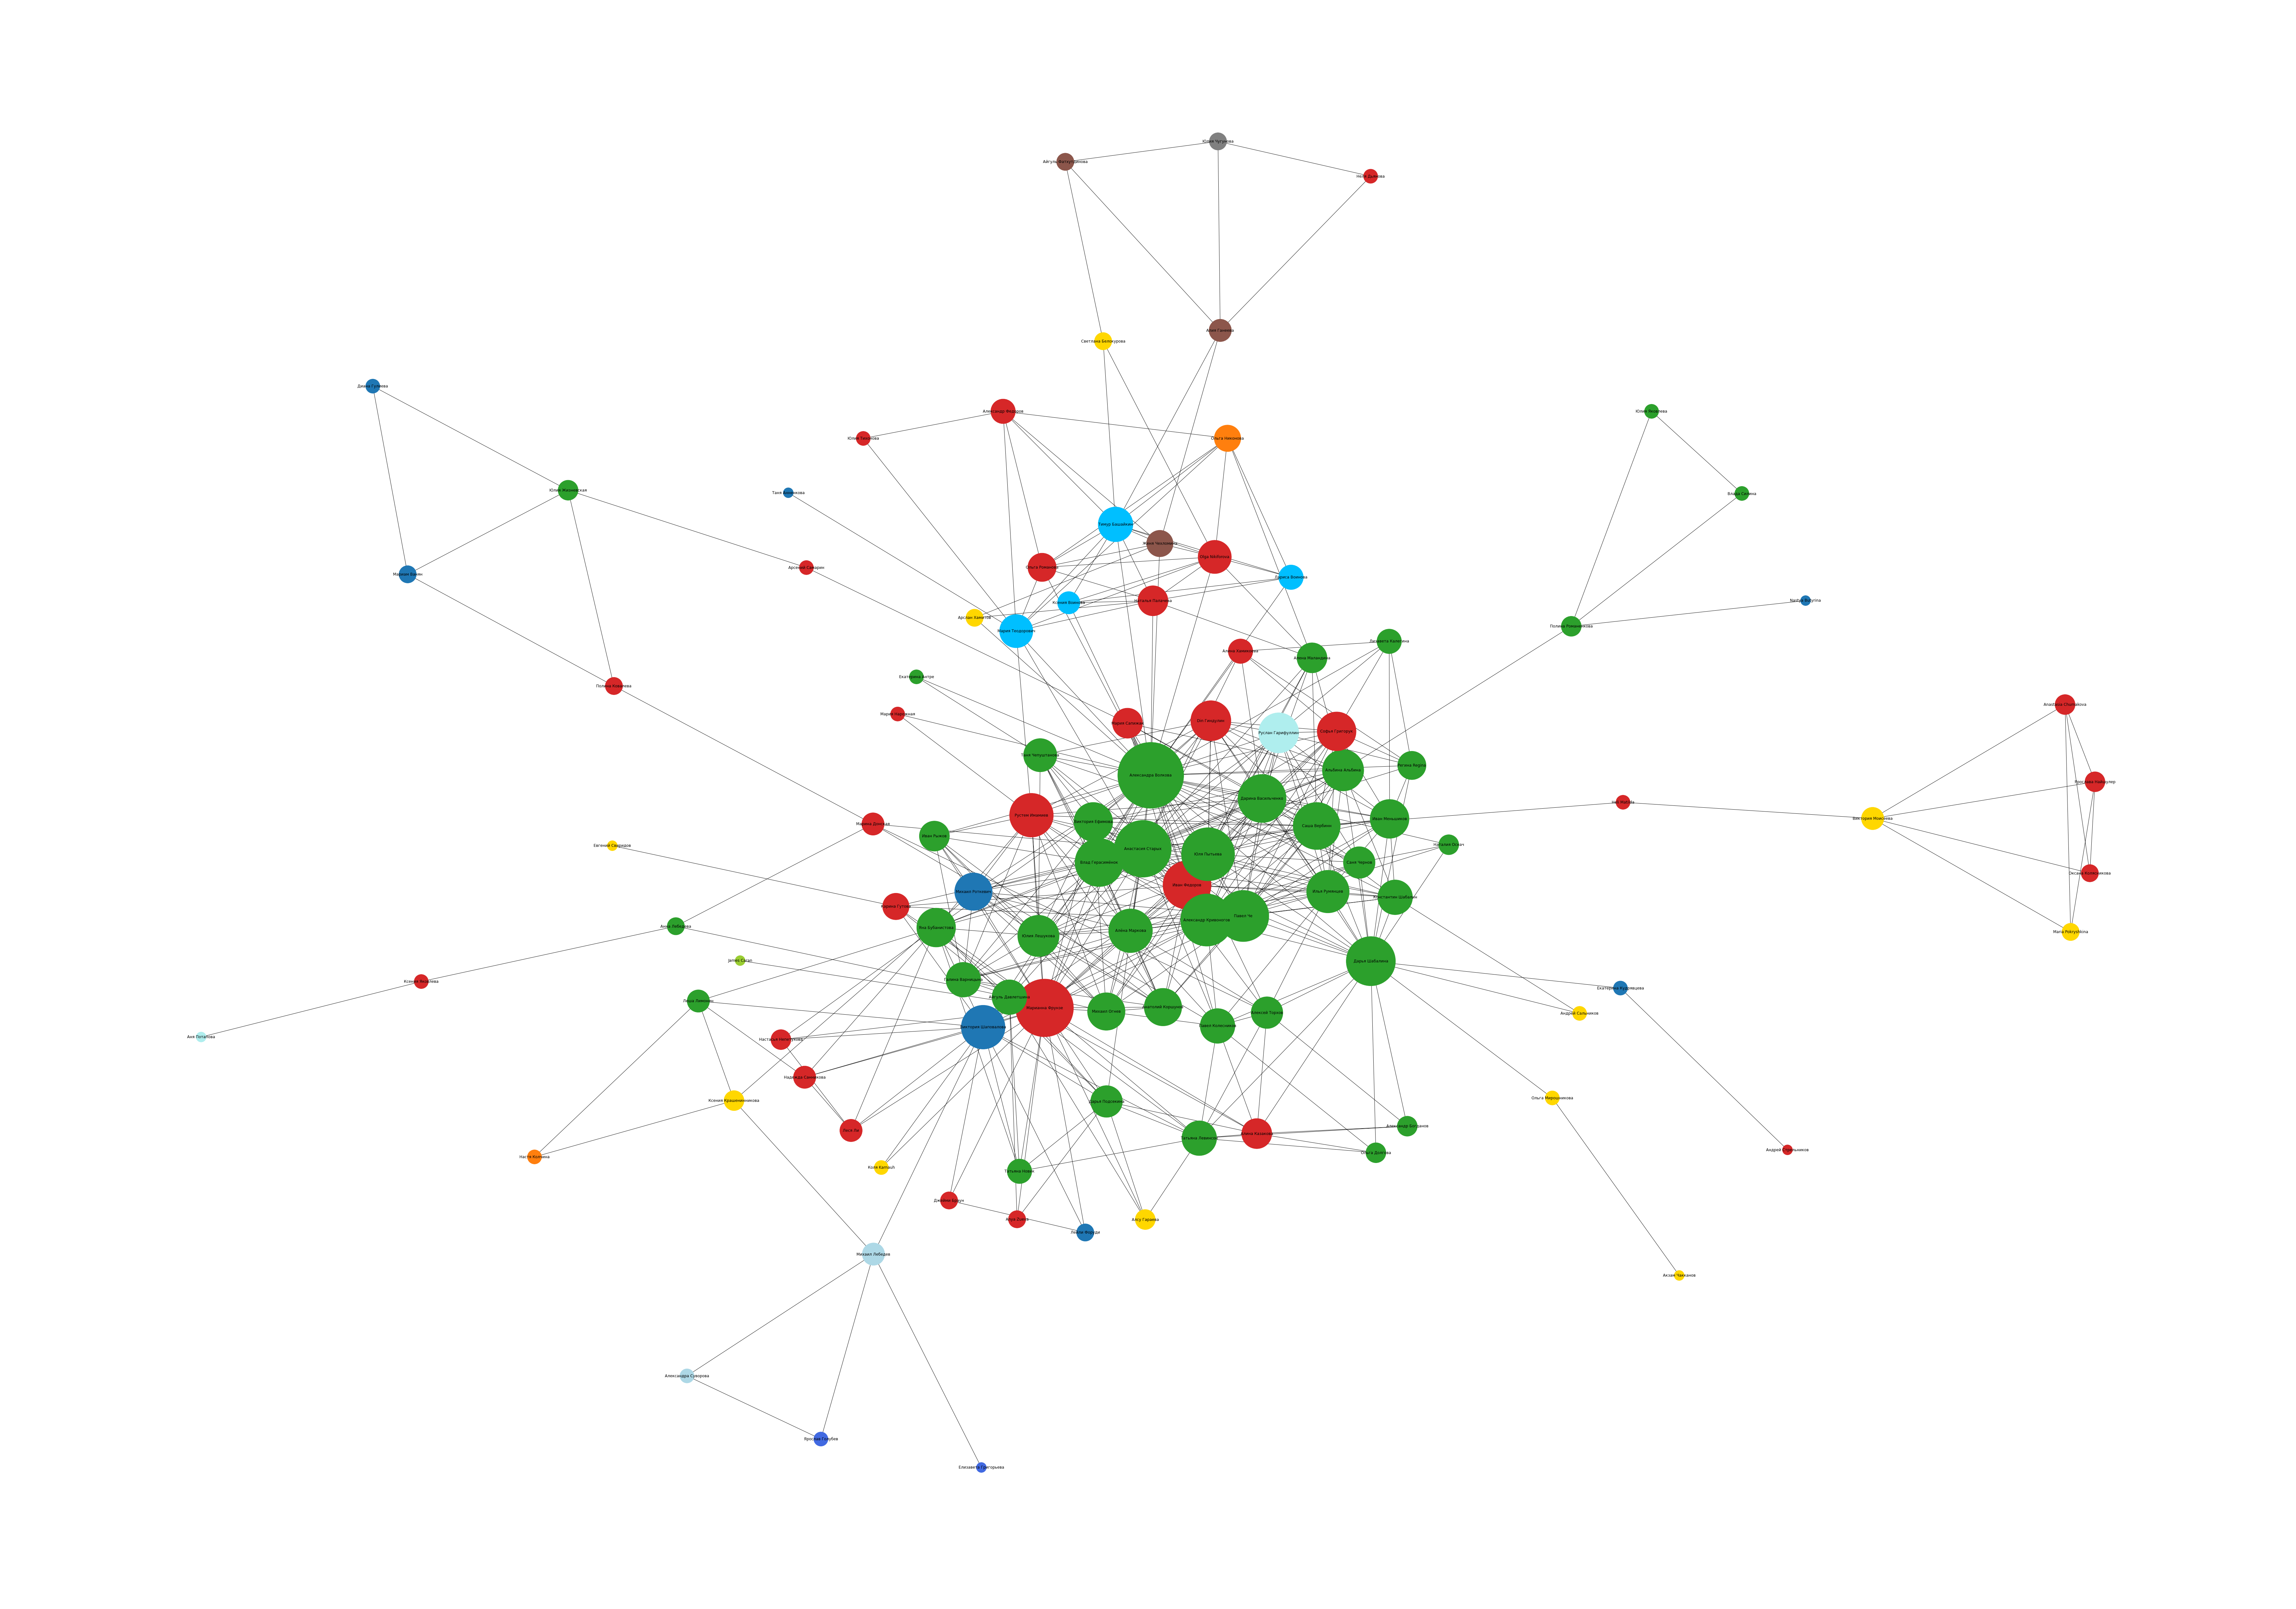

In [285]:
plt.figure(figsize=(100, 70))
layout = nx.kamada_kawai_layout(gg)
nx.draw(gg,
        pos = layout,
        labels=nx.get_node_attributes(gg, 'name'),
        node_color=list(nx.get_node_attributes(gg, 'color').values()),
        node_size=list(nx.get_node_attributes(gg, 'size').values())
       )

### Simple statistics

Lets count simple statistics:

In [160]:
print('Number of nodes:', len(gg.nodes))
print('Number of edges:', len(gg.edges))
print('Diameter:', nx.diameter(gg))
print('Radius:', nx.radius(gg))
print('Average shortest path length: ', nx.average_shortest_path_length(gg))
print('Average clustering coefficient: ', nx.average_clustering(gg))

Number of nodes: 108
Number of edges: 476
Diameter: 8
Radius: 4
Average shortest path length:  3.1478020076150917
Average clustering coefficient:  0.5773251551486372


Here we visualize clustering coefficients for the graph.

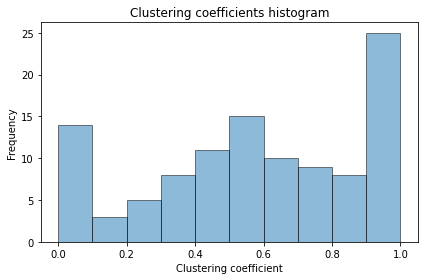

In [406]:
lcc = nx.clustering(gg)

plt.hist(lcc.values(), bins=10, alpha=0.5, histtype='bar', ec='black')
plt.title('Clustering coefficients histogram')
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The local clustering coefficient of a node in a graph quantifies how close its neighbours are to being a clique complete graph, which means the graph where all nodes are connected between each other.  
By this histogram we can tell that there are nodes that are tightly connected, but also nodes that are more separate.

Let us analyse shortest path lengths. Here is a histogram of shortest path lengths between each pair of nodes.

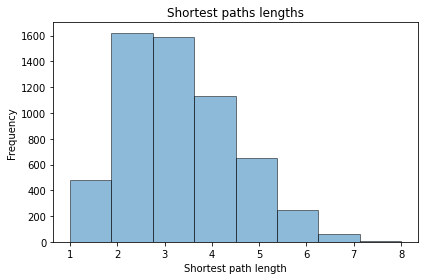

In [210]:
lcc = shortest_path_lengths

plt.hist(lcc, bins=len(Counter(shortest_path_lengths)), alpha=0.5, histtype='bar', ec='black')
plt.title('Shortest paths lengths')
plt.xlabel('Shortest path length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We see that the longest “shortest path” has only length of 8, which means the graph is quite tigtly connected. Most paths are in interval of 2-3 edges.

### Degree distribution

Here is the calculation of Degree distribution for the graph.

In [554]:
list_of_degrees = []
for key, value in dict(gg.degree).items():
    list_of_degrees.append(value)

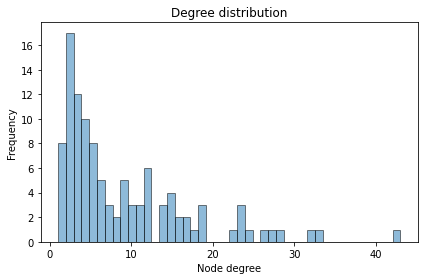

In [408]:
plt.hist(list_of_degrees, bins=len(nx.degree_histogram(gg)), alpha=0.5, histtype='bar', ec='black')
plt.title('Degree distribution')
plt.xlabel('Node degree')
plt.ylabel('Frequency')
plt.plot(points, pdf, color='r')
plt.tight_layout()
plt.show()

Most nodes have degree from 1 to 5. By the eye it does look similar to Power law distribution.

Now lets analyse the PDF of our distribution and of Power Law Distribution. To build correct Power Law distribution we need to calculate alpha. For that we will take empirical distribution and calculate alpha from there using regression.

In [409]:
def alpha_lin_bins(x_train):
    from sklearn.linear_model import LinearRegression 
    y, x = np.histogram(x_train, bins=20, density=True)
    new_x = (x[1:] + x[:-1]) / 2
    reg = LinearRegression()
    reg.fit(np.log(new_x[y>0]).reshape(-1, 1), np.log(y[y>0]))
    return - reg.coef_[0]

In [426]:
alpha_pred = alpha_lin_bins([degree for node, degree in gg.degree()])
alpha_pred

1.2154797693074315

Now we can compare empirical and theoretical PDF.

In [473]:
def empirical_pdf(G):
    pdf = np.array(nx.degree_histogram(G))
    pdf = pdf/sum(pdf)
    return pdf

In [427]:
def power_law_pdf(x, alpha=alpha_pred, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

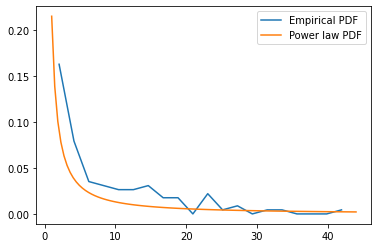

In [472]:
# Compute a histogram of our distribution
histogram, bins = np.histogram([degree for node, degree in gg.degree()], bins=20, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
# Theoretical PDF
x_space = np.linspace(1, len(nx.degree_histogram(gg)), 100)

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram, label="Empirical PDF")
plt.plot(x_space, power_law_pdf(x_space), label="Power law PDF")
plt.legend()
plt.show()

They seem very similar. Now we have to compare them via Kolmogorov-Smirnov test. Lets perform it. Null hypothesis will be that the samples belong to the same distribution.

In [474]:
import scipy
from scipy import stats
scipy.stats.kstest(empirical_pdf(gg), power_law_pdf(x_space))

KstestResult(statistic=0.38636363636363635, pvalue=0.00013402951912666605)

In [476]:
scipy.stats.kstest(empirical_pdf(gg), power_law_pdf(x_space)).pvalue < 0.05

True

P-value is much less than 0.05, so we have to reject the null hypothesis.

### Degree/Closeness/Betweenness/Eigenvector centralities, top nodes description.

Here we compute the main centralities for our graph and analyse them. I decided to take top-3 in each category.

In [302]:
def top3_centralities(G: nx.Graph):

    degree_cent = nx.degree_centrality(G) 
    closeness_cent = nx.closeness_centrality(G) 
    betweenness_cent = nx.betweenness_centrality(G) 
    eigenvector_cent = nx.eigenvector_centrality(G)
    personas = [] 
    degree_centrality = [] 
    closeness_centrality = [] 
    betweenness_centrality = []
    eigenvector_centrality = []
    for node in G.nodes: 
        personas.append(G.nodes[node]['name'])
        degree_centrality.append(degree_cent[node]) 
        closeness_centrality.append(closeness_cent[node]) 
        betweenness_centrality.append(betweenness_cent[node])
        eigenvector_centrality.append(eigenvector_cent[node])
        
    df_degree_cent = pd.DataFrame(
        {
            'person': personas,
            'centrality': degree_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(3)
    
    df_closeness_cent = pd.DataFrame(
        {
            'person': personas,
            'centrality': closeness_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(3)
    
    df_betweenness_cent = pd.DataFrame(
        {
            'person': personas,
            'centrality': betweenness_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(3)
    
    df_eigenvector_cent = pd.DataFrame(
        {
            'person': personas,
            'centrality': eigenvector_centrality
        }
    ).sort_values(by='centrality', ascending=False).head(3)
    
    top3 = {
        'degree': df_degree_cent,
        'closeness': df_closeness_cent,
        'betweenness': df_betweenness_cent,
        'eigenvector': df_eigenvector_cent,
    }
    return top3

In [268]:
top3_centralities(gg)['degree']

person  centrality
6   Александра Волкова    0.401869
17     Марианна Фрунзе    0.308411
9     Анастасия Старых    0.299065

The degree of a node of a graph is the number of edges that are incident to the node. Which means, the people who are represented by central nodes, counting by the degree, have the biggest number of friend among my friends. So this means we have biggest amount of mutual friends with them. Which is proved by the actual data: with Alexandra we have 43 mutual friends, with Marianna - 33 mutual friends, with Anastasia - 32 mutual friends.

In [269]:
top3_centralities(gg)['closeness']

person  centrality
6   Александра Волкова    0.529703
9     Анастасия Старых    0.495370
23         Юля Пытьева    0.461207

Closeness centrality of a node is calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes. Which means, if we want to spread the information to the whole network, but we need to choose, for example, 3 people, to whom we will tell it, and we consider that information spreads with equal time between each node, these are three people we need to choose to tell the information to. This doesn't mean that we have biggest amount of mutual friends with these people, but it means that they have shortest access to other people in the network.

In [270]:
top3_centralities(gg)['betweenness']

person  centrality
6   Александра Волкова    0.332067
9     Анастасия Старых    0.131487
17     Марианна Фрунзе    0.124328

The betweenness centrality for each node is the number of shortest paths that pass through the node. This means that the biggest amount of information goes through these nodes in the network. So maybe lifewise it means that these people know the most information about all other people in the network altogether.

In [303]:
top3_centralities(gg)['eigenvector']

person  centrality
6   Александра Волкова    0.271048
23         Юля Пытьева    0.254491
9     Анастасия Старых    0.247444

Eigenvector centrality is a measure of the influence of a node in a network. It is based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores. I am not sure how to interpret it in terms of ego network, but I may suggest that if we want the network to agree on some point, the most effective way will be to persuade the people who are represented by nodes with biggest eigenvector centralities.

Since Katz centrality is a variant of the eigenvector centrality, but it is more complicated computationally and requires more computer resource, I didn't calculate Katz centrality for the nodes.

### Community Detection

Here we will try to detect communities by Girvan-Newman algorithm. I would like to test the hypothesis that the communities in the graph will be somewhat similar to the division by the universities I made in the beginning. Lets check this.  
First we will calculate the list of labels of communities for each number of communities.

In [345]:
from networkx.algorithms.community.centrality import girvan_newman
labels_of_community = [i for i in girvan_newman(gg)]

I wrote a function that will return a list of color numbers for each node, depending on how many communities we divide.

In [355]:
def color_labels(G, n):
    labels_of_community = [i for i in girvan_newman(G)]
    color_labels = []
    dict_color_labels = {}
    i = 0
    for group in labels_of_community[n]:
        for node in group:
            dict_color_labels[node]=i
        i+=1   
    for node in G.nodes:
        color_labels.append(dict_color_labels[node])
    return color_labels

Let's visualize the clustering for several number of communities, from 2 to 13, because we have 13 groups of Universities and we will be able to compare the results.

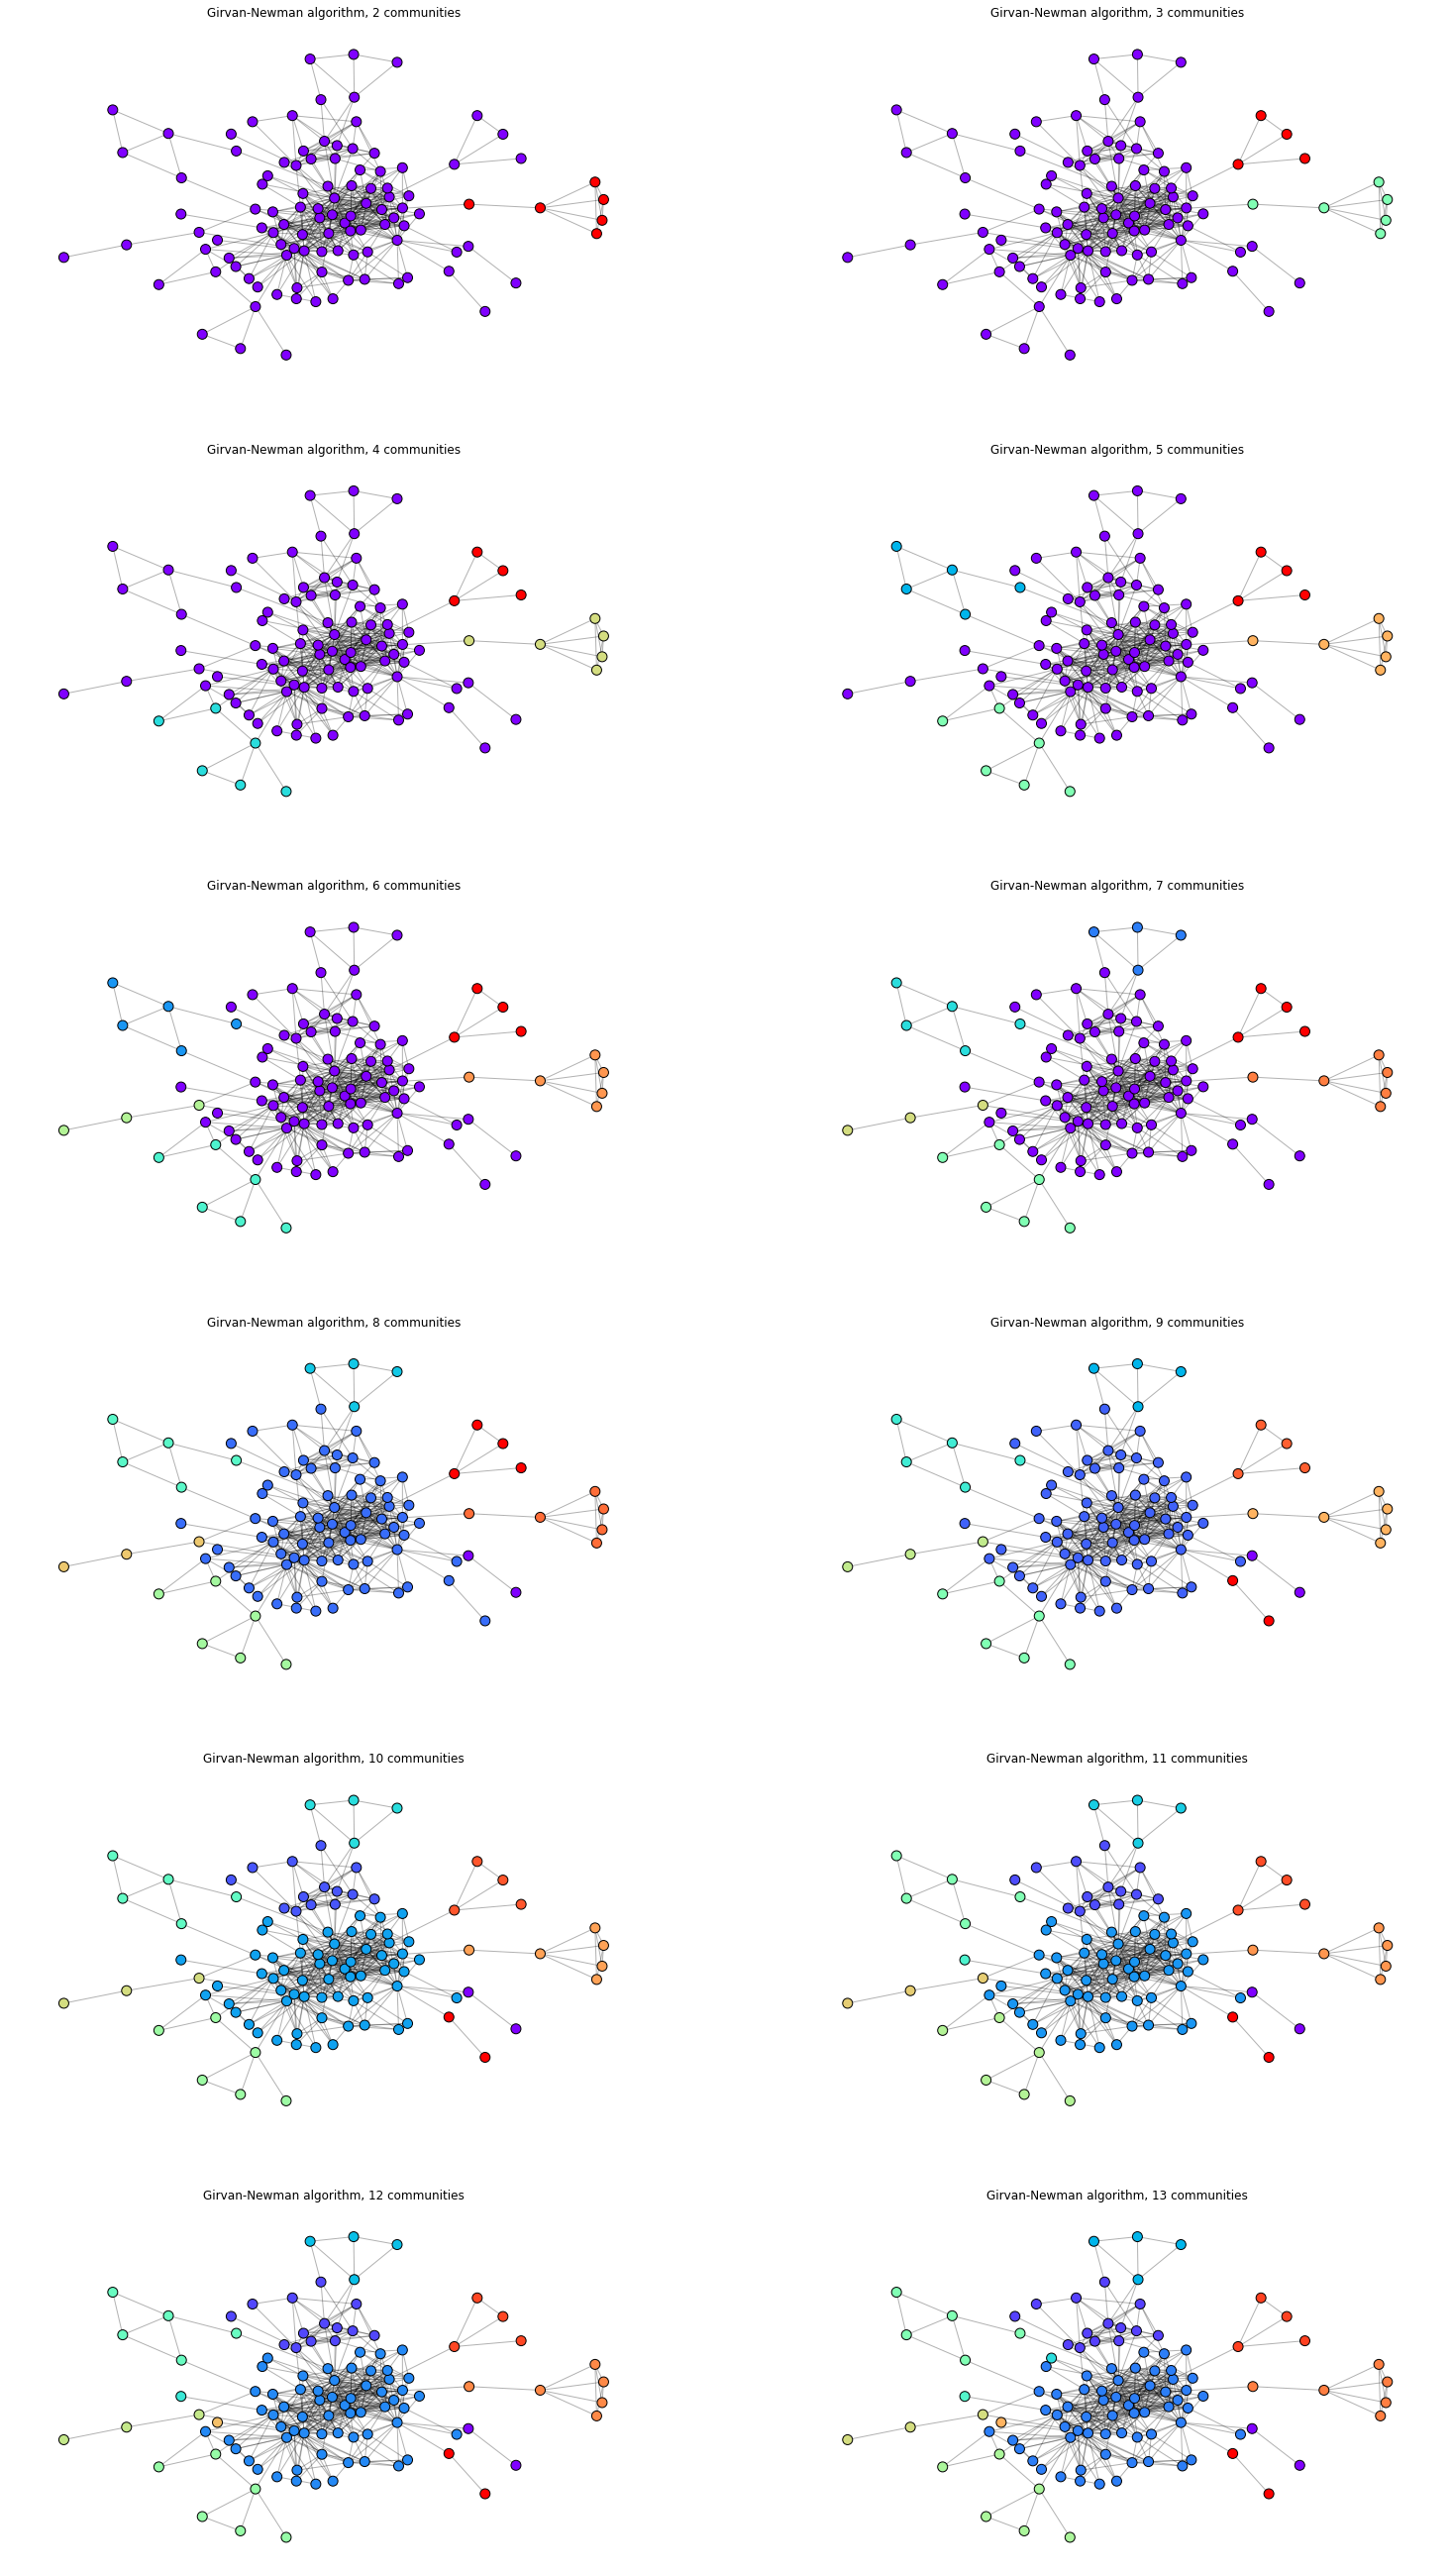

In [481]:
pos = nx.kamada_kawai_layout(gg)
plt.figure(figsize=(len(university_color)*2, len(university_color)*8))
for i in range(len(university_color)-1):
    plt.subplot(len(university_color), 2, i+1)
    nx.draw_networkx_nodes(
        gg, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=color_labels(gg, i), 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(gg, pos, alpha=0.3)
    plt.title('Girvan-Newman algorithm, {} communities'.format(i+2))
    plt.axis('off')

Another clustering algorythm, Louvain method, suggests that it creates an optimal amount of communities to divide the graph. Let's use this algorythm to set the color labels to then draw a graph.

In [368]:
def color_labels_louvain(G):
    labels_of_community = nx_comm.louvain_communities(G, seed=123)
    color_labels = []
    dict_color_labels = {}
    i = 0
    for group in labels_of_community:
        for node in group:
            dict_color_labels[node]=i
        i+=1   
    for node in G.nodes:
        color_labels.append(dict_color_labels[node])
    return color_labels

In [373]:
len(Counter(color_labels_louvain(gg)))

8

We see that the algorythm stated that the best will be to divide the nodes into 8 communities.

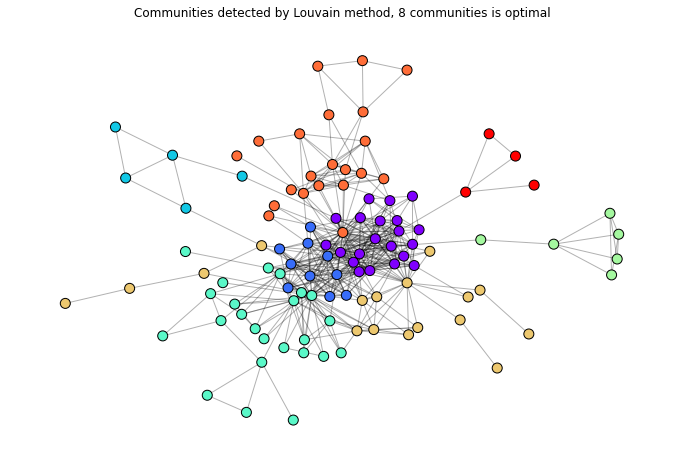

In [380]:
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(
    gg, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=color_labels_louvain(gg), 
    node_size=100, 
    edgecolors='black'
)
nx.draw_networkx_edges(gg, pos, alpha=0.3)
plt.title('Communities detected by Louvain method, '+str(len(Counter(color_labels_louvain(gg))))+\
          ' communities is optimal')
plt.axis('off');

Let's compare it to the result of Girvan-Newman algorythm, performed for 8 communities:

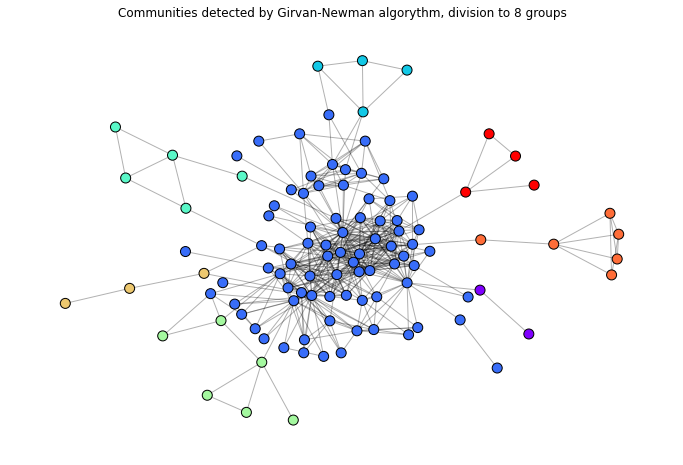

In [388]:
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(
    gg, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=color_labels(gg, 6), 
    node_size=100, 
    edgecolors='black'
)
nx.draw_networkx_edges(gg, pos, alpha=0.3)
plt.title('Communities detected by Girvan-Newman algorythm, division to 8 groups')
plt.axis('off');

How to compare them? I think that for the network that represents people, the best way to check if the community detection is correct is to find out whether people in communities know each other. By the eye I see that in Louvain method not so many people from each community know each other. To check in mathematically, I create a knowledge coefficient, which will be calculated as the sum of actual edges in community divided by the number of pairs of people.

For Louvain method:

In [539]:
dict_of_colors_for_alg_comp = {}
for i in range(len(gg.nodes)):
    dict_of_colors_for_alg_comp[np.array(gg.nodes)[i]] = color_labels_louvain(gg)[i]
    i+=1
list_of_edges_percents = []
for color in Counter(color_labels_louvain(gg)):
    n_edges = 0
    nodes_in_group = []
    for key, value in dict_of_colors_for_alg_comp.items():
        if value == color:
            nodes_in_group.append(key)
    list_of_pairs = [[nodes_in_group[p1], nodes_in_group[p2]] for p1 in range(len(nodes_in_group))\
          for p2 in range(p1+1,len(nodes_in_group))]
    for pair in list_of_pairs:
        if pair in list_of_edges:
            n_edges+=1
    list_of_edges_percents.append(n_edges/len(list_of_pairs))

In [525]:
np.array(list_of_edges_percents).mean()

0.41141393151463485

For Girvan-Newman algorithm:

In [540]:
dict_of_colors_for_alg_comp_GN = {}
GN_colors = color_labels(gg, 6)
for i in range(len(gg.nodes)):
    dict_of_colors_for_alg_comp_GN[np.array(gg.nodes)[i]] = GN_colors[i]
list_of_edges_percents = []
for color in Counter(color_labels(gg, 6)):
    n_edges = 0
    nodes_in_group = []
    for key, value in dict_of_colors_for_alg_comp_GN.items():
        if value == color:
            nodes_in_group.append(key)
    list_of_pairs = [[nodes_in_group[p1], nodes_in_group[p2]] for p1 in range(len(nodes_in_group))\
          for p2 in range(p1+1,len(nodes_in_group))]
    for pair in list_of_pairs:
        if pair in list_of_edges:
            n_edges+=1
    list_of_edges_percents.append(n_edges/len(list_of_pairs))

In [538]:
np.array(list_of_edges_percents).mean()

0.4276931401931402

So by a few percent points Girvan-Newman algorithm wins, and proves what I expected based on my knowledge of people in the network.

Just out of curiosity, I would like to compare the Girvan-Newman algorythm for 13 communities, and the graph based on the Uni a person studied in. This will let me check the hypothesis that University makes people become a community.

Let's draw a graph based on University.

In [401]:
uni_to_color = {}
for count, value in enumerate(university_color):
    uni_to_color[value] = count
node_to_color_by_uni = {}
for node in dict_of_unis:
    node_to_color_by_uni[node] = uni_to_color[dict_of_unis[node]]
list_of_colors_by_uni = []
for node in gg.nodes:
    list_of_colors_by_uni.append(node_to_color_by_uni[node])
# list_of_colors_by_uni

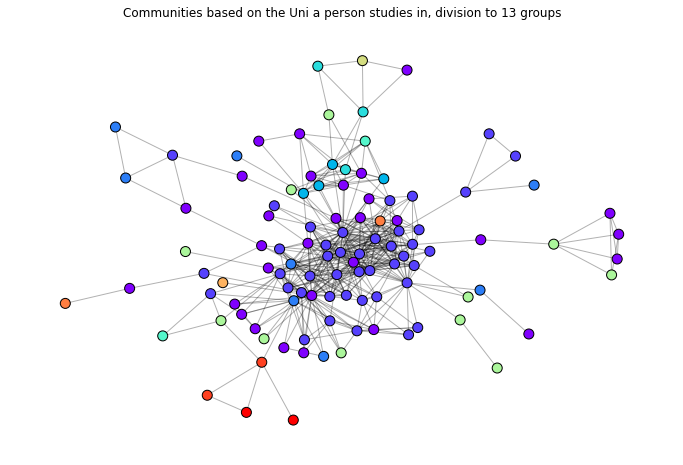

In [543]:
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(
    gg, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=list_of_colors_by_uni, 
    node_size=100, 
    edgecolors='black'
)
nx.draw_networkx_edges(gg, pos, alpha=0.3)
plt.title('Communities based on the Uni a person studies in, division to 13 groups')
plt.axis('off');

And the Girvan-Newman algorithm divided by 13 communities:

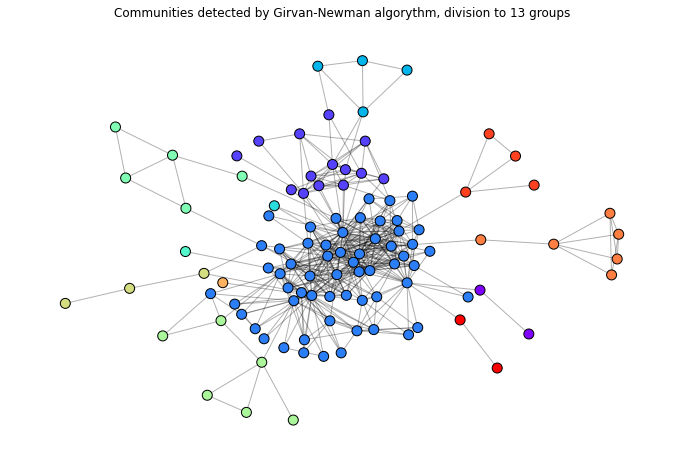

In [545]:
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(
    gg, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=color_labels(gg, 11), 
    node_size=100, 
    edgecolors='black'
)
nx.draw_networkx_edges(gg, pos, alpha=0.3)
plt.title('Communities detected by Girvan-Newman algorythm, division to 13 groups')
plt.axis('off');

The graphs look very different visually. Let's check the Knowledge coefficient for University community division.

In [551]:
dict_of_colors_for_alg_comp_UNI = {}
for i in range(len(gg.nodes)):
    dict_of_colors_for_alg_comp_UNI[np.array(gg.nodes)[i]] = list_of_colors_by_uni[i]
list_of_edges_percents = []
for color in Counter(list_of_colors_by_uni):
    n_edges = 0
    nodes_in_group = []
    for key, value in dict_of_colors_for_alg_comp_UNI.items():
        if value == color:
            nodes_in_group.append(key)
    list_of_pairs = [[nodes_in_group[p1], nodes_in_group[p2]] for p1 in range(len(nodes_in_group))\
          for p2 in range(p1+1,len(nodes_in_group))]
    for pair in list_of_pairs:
        if pair in list_of_edges:
            n_edges+=1
    if len(list_of_pairs) != 0:
        list_of_edges_percents.append(n_edges/len(list_of_pairs))
np.array(list_of_edges_percents).mean()

0.13557636924331623

And for G-N algorithm for 13 communities:

In [553]:
dict_of_colors_for_alg_comp_GN = {}
GN_colors = color_labels(gg, 11)
for i in range(len(gg.nodes)):
    dict_of_colors_for_alg_comp_GN[np.array(gg.nodes)[i]] = GN_colors[i]
list_of_edges_percents = []
for color in Counter(GN_colors):
    n_edges = 0
    nodes_in_group = []
    for key, value in dict_of_colors_for_alg_comp_GN.items():
        if value == color:
            nodes_in_group.append(key)
    list_of_pairs = [[nodes_in_group[p1], nodes_in_group[p2]] for p1 in range(len(nodes_in_group))\
          for p2 in range(p1+1,len(nodes_in_group))]
    for pair in list_of_pairs:
        if pair in list_of_edges:
            n_edges+=1
    if len(list_of_pairs) != 0:
        list_of_edges_percents.append(n_edges/len(list_of_pairs))
np.array(list_of_edges_percents).mean()

0.4865795980757991

We see that the Knowledge coefficient for Uni division is very low, so University a person studied in is not an argument for them to belong to a certain community. Partly these results may be not correct because I combined some Universities into "other" category, and also for many nodes there is no such information.